In [120]:
pip install python-dotenv spotipy yellowbrick


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
   --------------------------------------- 282.6/282.6 kB 17.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: C:\Users\rodyv\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Extraccion de canciones "Me gusta" y creacion de playlist

## Obtencion de canciones con me gusta

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Autenticacion

In [50]:
from dotenv import load_dotenv
import os
import spotipy
from spotipy.oauth2 import SpotifyOAuth

# Cargar las variables desde el archivo .env
load_dotenv(".env")

scope = 'user-library-read,playlist-modify-public,playlist-modify-private'

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=os.getenv('SPOTIPY_CLIENT_ID'),
    client_secret=os.getenv('SPOTIPY_CLIENT_SECRET'),
    redirect_uri=os.getenv('SPOTIPY_REDIRECT_URI'),
    scope=scope
))


### Obtener canciones

In [51]:

results = sp.current_user_saved_tracks()
tracks = results['items']

while results['next']:
    results = sp.next(results)
    tracks.extend(results['items'])

print(f'Total de canciones: {len(tracks)}')


Total de canciones: 573


### DF con las canciones y sus generos asociados

In [72]:
from tqdm import tqdm
import time

track_data = []

# Lista de claves de características de audio
audio_feature_numerical_keys = [
    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence',
]
audio_feature_categorical_keys = ['tempo', 'time_signature', 'key', 'mode']

def get_key(f, key):
    return f[key] if key in f else None

# Iterar sobre las pistas
for item in tqdm(tracks,  desc="Procesando pistas", unit="pista"):
    try:
        track = item['track']
        artist_id = track['artists'][0]['id']
        track_id = track['id']
        
        artist_info = sp.artist(artist_id)
        audio_features = sp.audio_features(track_id)[0]
        
        genre = artist_info['genres'] if 'genres' in artist_info else []
        
        track_info = {
            'id': track_id,
            'name': track['name'],
            'artist': track['artists'][0]['name'],
            'genre': genre
        }
        
        for key in audio_feature_numerical_keys:
            track_info[key] = get_key(audio_features, key)
        

        track_data.append(track_info)
    except Exception as e:
        print(f"Error al procesar {track['name']}: {e}")

df = pd.DataFrame(track_data)
df.head()

Procesando pistas: 100%|██████████| 573/573 [04:40<00:00,  2.05pista/s]

                       id                  name       artist  \
0  1qgtSWA2GbpAXfyC51M1ph                Por Ti          4x3   
1  5FAS5CyNd5jXR9wRpRtn3L       Inevitablemente          D2o   
2  3w3y8KPTfNeOKPiqUTakBh  Locked out of Heaven   Bruno Mars   
3  49FYlytm3dAAraYgpoJZux              Umbrella      Rihanna   
4  0JEoezwc786AUMKs2CBQRI           Carismático  Babasónicos   

                                               genre  danceability  energy  \
0                                  [latin viral rap]         0.761   0.535   
1                                                 []         0.690   0.449   
2                                   [dance pop, pop]         0.726   0.698   
3           [barbadian pop, pop, urban contemporary]         0.585   0.828   
4  [argentine rock, electronica argentina, latin ...         0.690   0.919   

   loudness  speechiness  acousticness  instrumentalness  liveness  valence  \
0    -7.665       0.0600       0.88200               0.0    0.1830 

In [53]:
# todos los géneros
all_genres = set()
for genres in df['genre']:
    all_genres.update(genres)

all_genres = list(all_genres)
print(all_genres)
print(f'Total de géneros: {len(all_genres)}')

['dance rock', 'bases de freestyle', 'rap marseille', 'french soundtrack', 'viking metal', 'slavic folk metal', 'urbano mexicano', 'folk', 'nueva trova chilena', 'canadian metal', 'folk-pop', 'pop venezolano', 'rap metal espanol', 'drill espanol', 'urban contemporary', 'power metal', 'lo-fi vgm', 'mexican rock', 'ska mexicano', 'colombian indie', 'mexican hip hop', 'alternative rock', 'argentine alternative rock', 'icelandic indie', 'indie valenciana', 'gym phonk', 'pop rap', 'latin metal', 'canadian electropop', 'metalcore', 'glam punk', 'blues rock', 'reggae catala', 'russian metal', 'dream pop', 'neo-psychedelic', 'mexican pop', 'lounge', 'hopebeat', 'french hip hop', 'argentine telepop', 'spanish folk metal', 'hi-nrg', 'bedroom pop', 'argentine heavy metal', 'sad lo-fi', 'canto popular uruguayo', 'funk mtg', 'canadian punk', 'tatar pop', 'argentine reggae', 'hardcore punk espanol', 'disco', 'classic schlager', 'viral rap', "women's music", 'spanish rock', 'rap metal', 'rap', 'elect

Aqui podemos analizar un poco, peeeero

Analisis de datos

Filas con valores nulos: 0


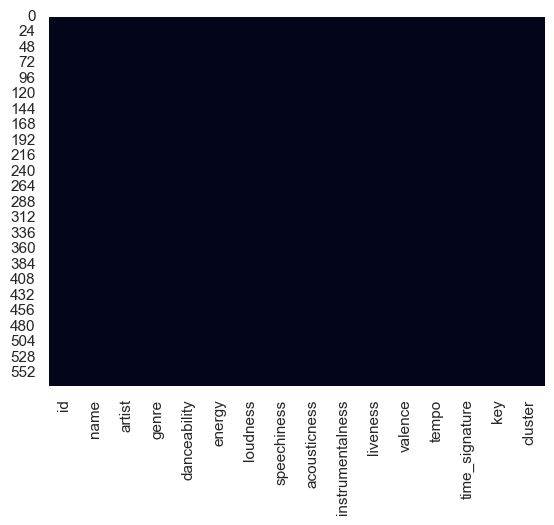

In [103]:
sns.heatmap(df.isnull(), cbar=False)
print(f'Filas con valores nulos: {df.isnull().sum().sum()}')

Distribucion de los datos

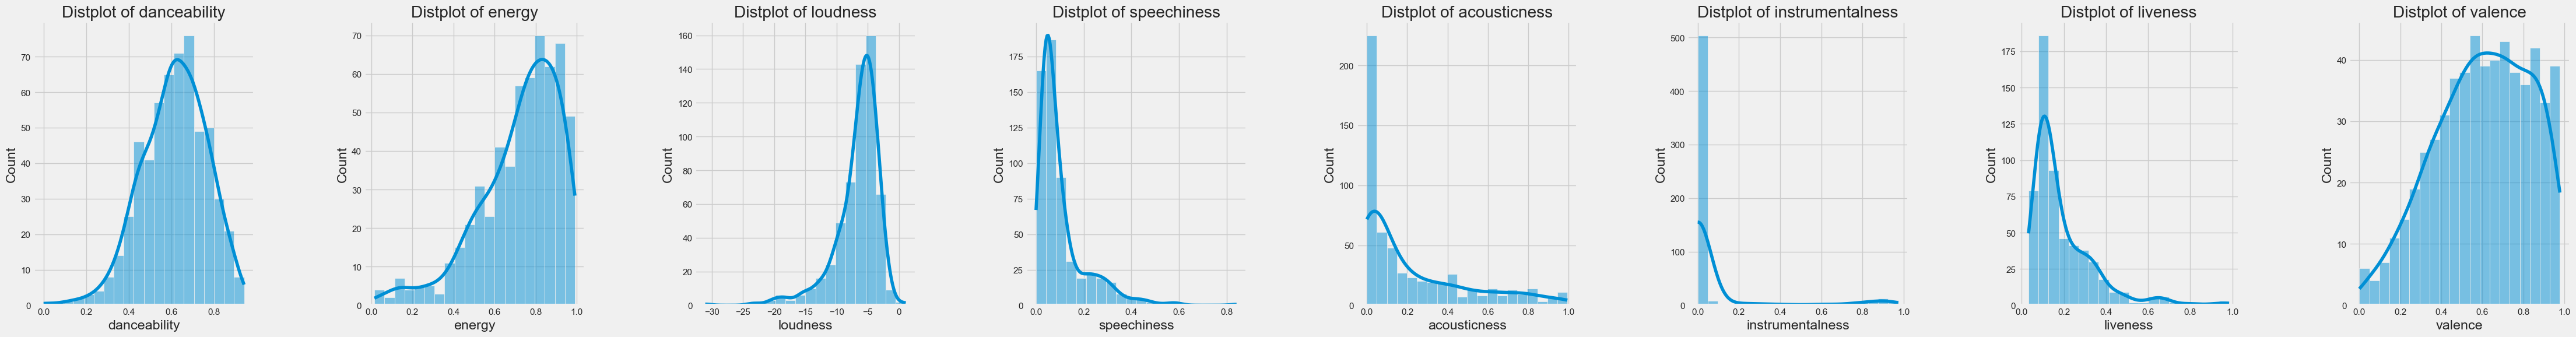

In [110]:
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (50 , 6))
n = 0 
for x in audio_feature_numerical_keys:
    n += 1
    plt.subplot(1 , len(audio_feature_numerical_keys) , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.histplot(df[x] , bins = 20, kde=True)
    plt.title('Distplot of {}'.format(x))
plt.show()

## Clustering

### K-Means 

In [119]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

ModuleNotFoundError: No module named 'yellowbrick'

La idea es usar TF-IDF (Term Frecuency - Inverse Document Frecuency) para representar los generos como vectores numericos

In [116]:
genres_list = [' '.join(genres) for genres in df['genre']]
track_genre_mapping = []

for i, genres in enumerate(df['genre']):
    for genre in genres:
        track_genre_mapping.append({
            'track': df['name'][i],
            'artist': df['artist'][i],
            'genre': genre
        })

track_genre_df = pd.DataFrame(track_genre_mapping)


Pero primero probaremos el rendimiento solo con los numericos

In [117]:
audio_features = df[audio_feature_numerical_keys].to_numpy() 


#### Normalizacion
para realizar el calculo de distancias correctamente.

In [118]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(genres_list) 

# Matriz numpy y normalización
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(audio_features)

#### Seleccion de nro de Clusterns
Se usara el metodo del codo, para emplear un criterio experto

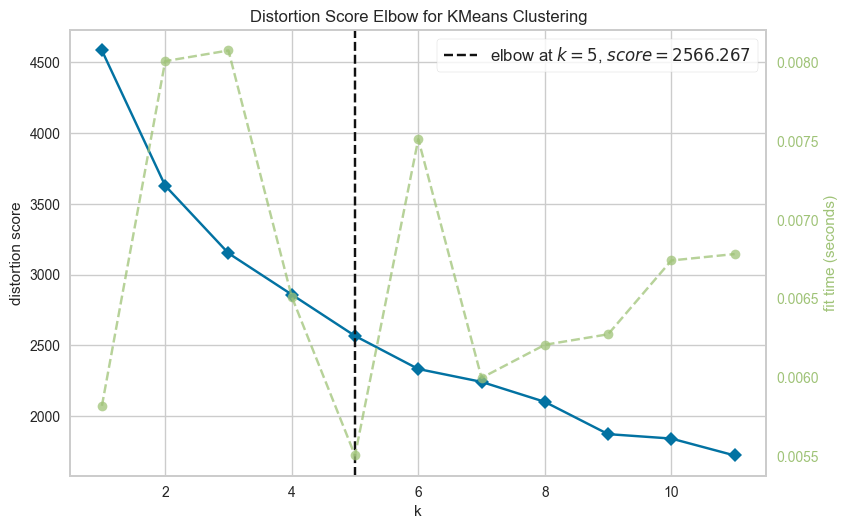

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [129]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(X_scaled)      
visualizer.show()        

#### Entrenamiento del modelo

In [141]:
n_clusters = 5
kmeans = KMeans(n_clusters = n_clusters ,init='k-means++', n_init = 10 ,max_iter=10000, 
                 tol=0.0001, algorithm='lloyd', random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_   
centroides = kmeans.cluster_centers_   

df['cluster'] =  labels

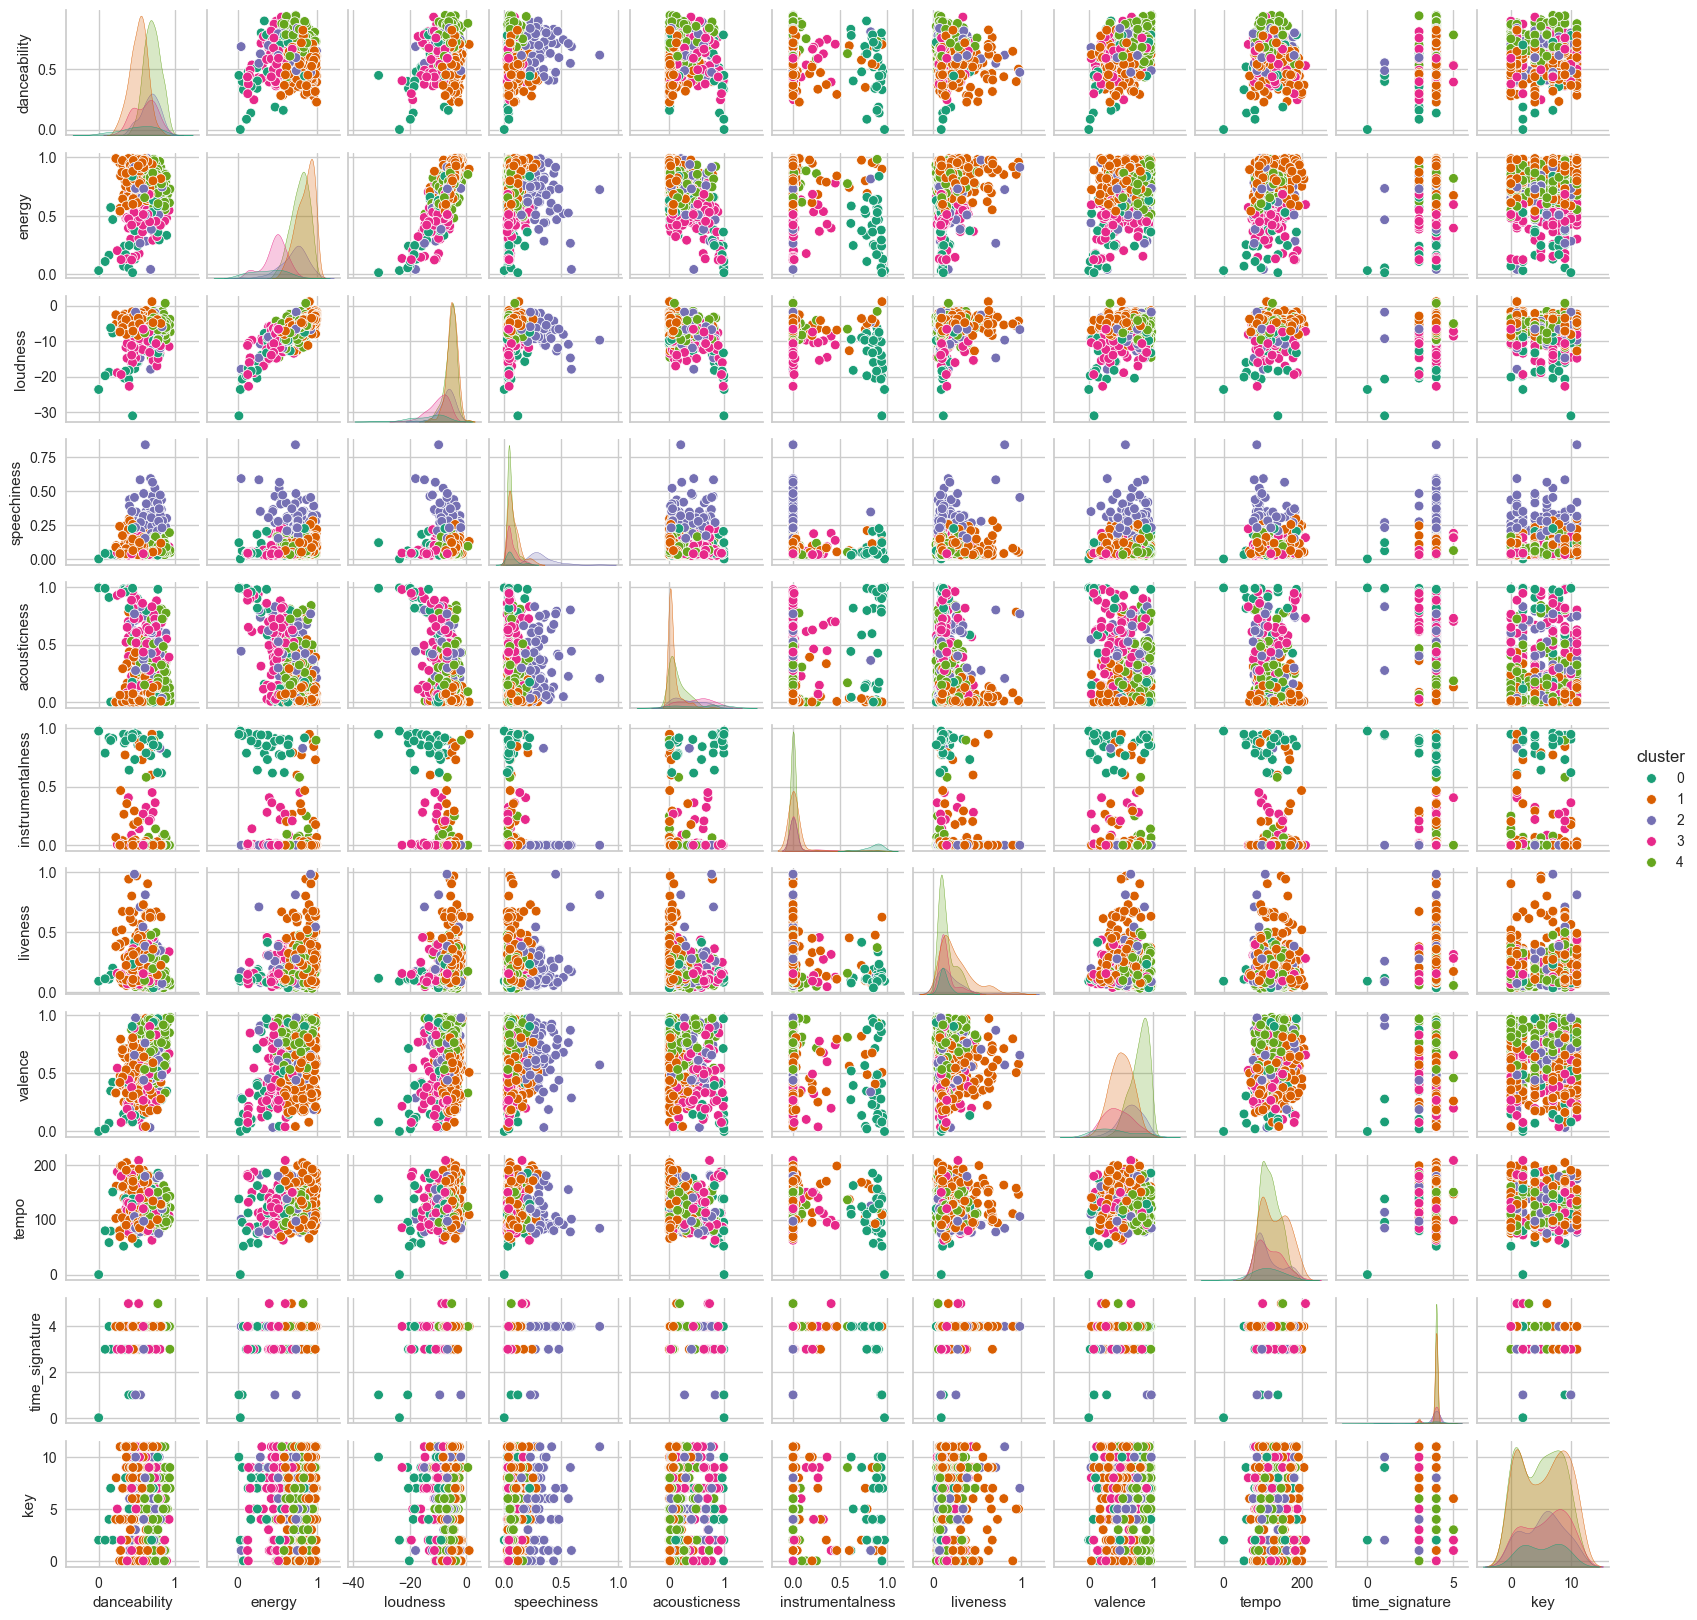

In [142]:
plot = sns.pairplot(df, hue='cluster', diag_kind='kde', palette='Dark2', height=1.5)
plt.show()


### Reduccion de dimensionalidad
Dado que usamos al menos 11 dimensiones para el clustering nos veremos obligados a reducir la dimensionalidad para poder observar los clusters sin dificultadad

In [144]:
from sklearn.decomposition import PCA
import pandas as pd
import plotly.express as px


# Ajustar el modelo PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_scaled)


df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
df_pca['cluster'] = df['cluster']


fig = px.scatter_3d(df_pca, 
                    x='PC1', 
                    y='PC2', 
                    z='PC3', 
                    color='cluster', 
                    height=800, 
                    width=800)

# Guardar el gráfico como un archivo HTML
fig.write_html("file5k.html")

# Mostrar el gráfico
fig.show()

Por si el grafico interactivo no se muestra en GH

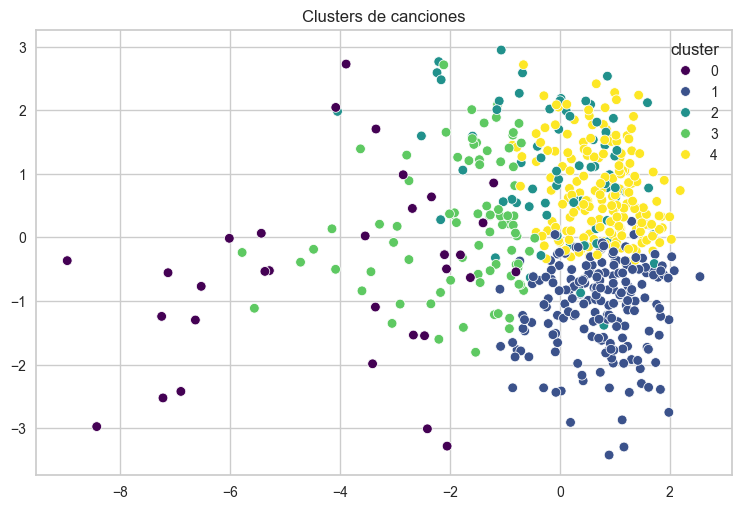

In [145]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='viridis')
plt.title('Clusters de canciones')
plt.show()


### Subir los clusters como playlist


In [146]:
df['cluster'].value_counts()

cluster
1    193
4    189
3     84
2     74
0     33
Name: count, dtype: int64

In [156]:
def add_tracks_to_playlist(playlist_id, tracks):
    print(f"Añadiendo {len(tracks)} pistas a la playlist {playlist_id}")
    for i in tqdm(range(0, len(tracks), 100)):  # Dividir en lotes de 100
        batch = tracks[i:i + 100]
        try:
            results = sp.playlist_add_items(playlist_id, batch)
        except spotipy.exceptions.SpotifyException as e:
            print(f"Error al añadir pistas a la playlist {playlist_id}: {e}")
            # Esperar medio segundo antes de intentar de nuevo
            time.sleep(0.5)
            continue



for i in tqdm(range(n_clusters), desc="Creando listas de reproducción", unit="cluster"):
    cluster_tracks = df[df['cluster'] == i]
    if not cluster_tracks.empty:
        playlist_name = f"Cluster {i+1} Playlist"
        
        try:
            # Crear la playlist
            playlist = sp.user_playlist_create(user=sp.current_user()['id'], name=playlist_name)
        except spotipy.exceptions.SpotifyException as e:
            print(f"Error al crear la playlist {playlist_name}: {e}")
            continue
        
        track_ids = cluster_tracks['id'].tolist()  # Obtener los IDs de las pistas directamente del DataFrame
        
        if track_ids:
            try:
                add_tracks_to_playlist(playlist['id'], track_ids)
                print(f"Lista de reproducción creada: {playlist_name}")
            except spotipy.exceptions.SpotifyException as e:
                print(f"Error al añadir pistas a la playlist {playlist_name}: {e}")
        else:
            print(f"No se añadieron pistas a la playlist: {playlist_name}")

Creando listas de reproducción:   0%|          | 0/5 [00:00<?, ?cluster/s]

Añadiendo 33 pistas a la playlist 3QRy0mcWR6dxYH08oqwwqc


Creando listas de reproducción:  20%|██        | 1/5 [00:00<00:03,  1.20cluster/s]

Lista de reproducción creada: Cluster 1 Playlist
Añadiendo 193 pistas a la playlist 7cDv9BET0oWPgdgNfZR1SP


Creando listas de reproducción:  40%|████      | 2/5 [00:01<00:03,  1.02s/cluster]

Lista de reproducción creada: Cluster 2 Playlist
Añadiendo 74 pistas a la playlist 1bGTXKKBGpTvRLg4v8TGbN


Creando listas de reproducción:  60%|██████    | 3/5 [00:02<00:01,  1.07cluster/s]

Lista de reproducción creada: Cluster 3 Playlist
Añadiendo 84 pistas a la playlist 087Oi5zykPXDyySWw3Bfdp


Creando listas de reproducción:  80%|████████  | 4/5 [00:03<00:00,  1.10cluster/s]

Lista de reproducción creada: Cluster 4 Playlist
Añadiendo 189 pistas a la playlist 7pz9ACKYdIlYOopstbXYeT


Creando listas de reproducción: 100%|██████████| 5/5 [00:04<00:00,  1.03cluster/s]

Lista de reproducción creada: Cluster 5 Playlist
